In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
import os

### VDSR (Very Deep Super Resolution)

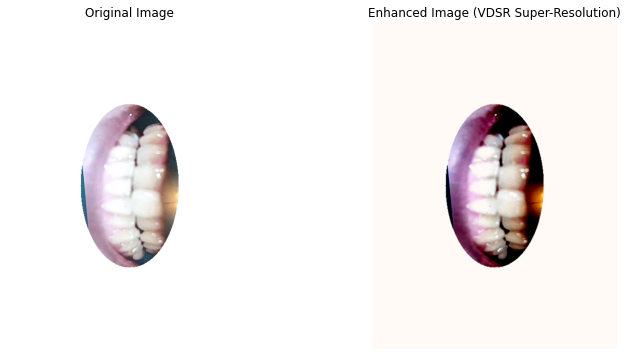

In [10]:


# VDSR Model Definition
class VDSR(nn.Module):
    def __init__(self):
        super(VDSR, self).__init__()
        self.residual_layer = self._make_layer(64, 20)
        self.input_layer = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.output_layer = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def _make_layer(self, channels, num_layers):
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.input_layer(x)
        out = self.residual_layer(out)
        out = self.output_layer(out)
        return out + residual

# Load Pretrained Model (if available) or define your training function
model = VDSR().to('cuda' if torch.cuda.is_available() else 'cpu')

# Load a sample image
image_path = 'img.png'  # Provide the correct path
image = Image.open(image_path).convert('RGB')

# Image preprocessing for inference
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image.height * 2, image.width * 2)),  # Super-resolution 2x upscale
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

input_image = transform(image).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

# Inference
model.eval()
with torch.no_grad():
    output_image_tensor = model(input_image)

# Post-process the output image
output_image_tensor = output_image_tensor.squeeze(0).clamp(0, 1).cpu()

# Convert tensor back to image
output_image = transforms.ToPILImage()(output_image_tensor)

# Display the original and enhanced images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Enhanced image
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title("Enhanced Image (VDSR Super-Resolution)")
plt.axis('off')

plt.show()


In [15]:

class VDSR(nn.Module):
    def __init__(self):
        super(VDSR, self).__init__()
        self.residual_layer = self._make_layer(64, 20)
        self.input_layer = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.output_layer = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def _make_layer(self, channels, num_layers):
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.input_layer(x)
        out = self.residual_layer(out)
        out = self.output_layer(out)
        return out + residual

def enhance_image(image_path, model_path=None, scale_factor=2, show_result=True, save_path=None):
    """
    Enhance an image using VDSR super-resolution model.
    
    Args:
        image_path (str): Path to the input image
        model_path (str, optional): Path to pretrained model weights
        scale_factor (int, optional): Factor by which to upscale the image (default: 2)
        show_result (bool, optional): Whether to display the results (default: True)
        save_path (str, optional): Path to save the enhanced image (default: None)
    
    Returns:
        tuple: (original_image, enhanced_image) as PIL Images
    """
    try:
        # Check if image exists
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found at {image_path}")

        # Device configuration
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Initialize model
        model = VDSR().to(device)
        
        # Load model weights if provided
        if model_path:
            if os.path.exists(model_path):
                model.load_state_dict(torch.load(model_path, map_location=device))
            else:
                print(f"Warning: Model weights not found at {model_path}")
        
        # Load and prepare image
        image = Image.open(image_path).convert('RGB')
        
        # Define image transformation
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((image.height * scale_factor, image.width * scale_factor)),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        # Prepare input
        input_image = transform(image).unsqueeze(0).to(device)
        
        # Model inference
        model.eval()
        with torch.no_grad():
            output_image_tensor = model(input_image)
        
        # Post-process output
        output_image_tensor = output_image_tensor.squeeze(0).clamp(0, 1).cpu()
        output_image = transforms.ToPILImage()(output_image_tensor)
        
        # Save enhanced image if path provided
        if save_path:
            output_image.save(save_path)
            print(f"Enhanced image saved to {save_path}")
        
        # Display results if requested
        if show_result:
            plt.figure(figsize=(12, 6))
            
            # Original image
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')
            
            # Enhanced image
            plt.subplot(1, 2, 2)
            plt.imshow(output_image)
            plt.title("Enhanced Image (VDSR)")
            plt.axis('off')
            
            plt.show()
        
        return image, output_image
        
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None, None
"""
# With all options
original, enhanced = enhance_image(
    image_path='path/to/image.jpg',
    model_path='path/to/model_weights.pth',
    scale_factor=3,
    show_result=True,
    save_path='path/to/save/enhanced.jpg'
)
"""


"\n# With all options\noriginal, enhanced = enhance_image(\n    image_path='path/to/image.jpg',\n    model_path='path/to/model_weights.pth',\n    scale_factor=3,\n    show_result=True,\n    save_path='path/to/save/enhanced.jpg'\n)\n"

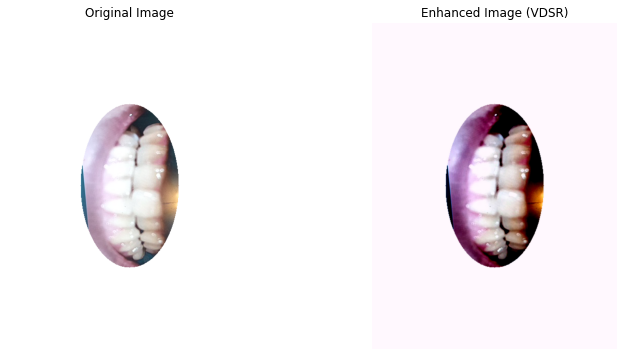

"\n# With all options\noriginal, enhanced = enhance_image(\n    image_path='path/to/image.jpg',\n    model_path='path/to/model_weights.pth',\n    scale_factor=3,\n    show_result=True,\n    save_path='path/to/save/enhanced.jpg'\n)\n"

In [14]:
# Example usage:

# Basic usage
original, enhanced = enhance_image('img.png')


In [ ]:
original, enhanced = enhance_image('img3.png')